In [2]:
import os
import re
import math
import glob
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Concatenate
 

In [3]:
def sort_dirs(path):
    path = os.path.basename(path)
    if path.startswith("."):
        return 0
    found = re.search(r'\((\d+)\)', path)
    if not found:
        return 0
    return int(found.group(1))

def sort_prod(file):
    if file.startswith("."):
        return 0
    try:
        found = re.search(r'2022-\d{2}-\d{2}', file)
        index = found.end()
    except Exception as e:
        print(f"ERR on {file}")
    return int(file[index - 2:file.index(".csv")])
    
def split_time_day(df):
    df[['time','day']] = (
        df['time_day']
           .str.split('/', expand=True)
           .apply(lambda col: col.str.strip())
    )
    df['day'] = df['day'].astype(int)
    df.drop('time_day', axis=1, inplace=True)
    return df

def parse_conditions(dir):
    path = os.path.join(os.getcwd(), dir)
    # Get diagram 1 data into a dataframe
    full_path = os.path.join(path, "Weather_Diagram_1*")
    diagram_1_data = []
    for file in sorted(glob.glob(full_path), key=sort_dirs):
        if file.startswith("."):
            continue
        data = pd.read_csv(file, sep=";",skiprows=1,header=None,
                           names=["time_day","ambient","module_temp","wind"])
        diagram_1_data.append(data)
    df1 = pd.concat(diagram_1_data, ignore_index=True)
    df1 = split_time_day(df1)
    
    # Get diagram 2 data into a dataframe
    full_path = os.path.join(path, "Weather_Diagram_2*")
    diagram_2_data = []
    for file in sorted(glob.glob(full_path), key=sort_dirs):
        if file.startswith("."):
            continue
        data = pd.read_csv(file, sep=";",skiprows=1,header=None,
                           names=["time_day","insolation"])
        diagram_2_data.append(data)
    df2 = pd.concat(diagram_2_data, ignore_index=True)
    df2 = split_time_day(df2)
    
    # Merge into one dataframe
    combined_df = pd.merge(df1,df2,on=['day','time'])
    return combined_df
    
def parse_production(dir):
    path = os.path.join(os.getcwd(), dir)
    df = []
    for file in sorted(os.listdir(path),key=sort_prod):
        if file.startswith("."):
            continue
        full_path = f"{path}/{file}"
        data = pd.read_csv(full_path, sep=";",skiprows=1,header=None, 
                           names=["time","power"])
        day = int(file.split("-")[-1].split(".")[0])
        data['day'] = day
        df.append(data)
    df = pd.concat(df, ignore_index=True)
    df['time'] = df['time'].str.strip()
    df['power'] = pd.to_numeric(df['power'], errors='coerce')
    return df
    
# Load data
data_dir = "PVSystem/"

all_inputs = []
all_outputs = []
by_month_data = dict()
for dir in sorted(os.listdir(data_dir)):
    full_path = os.path.join(data_dir, dir)
    if not os.path.isdir(full_path) or dir.startswith("."):
        continue
    cond_df = parse_conditions(full_path + '/Conditions')
    prod_df = parse_production(full_path + '/Production')
    all_inputs.append(cond_df.assign(month=dir))
    all_outputs.append(prod_df.assign(month=dir))
    
    by_month_data[dir] = dict()
    by_month_data[dir]['cond'] = []
    by_month_data[dir]['prod'] = []
    by_month_data[dir]['cond'].append(cond_df.assign(month=dir))
    by_month_data[dir]['prod'].append(prod_df.assign(month=dir))

all_inputs = pd.concat(all_inputs, ignore_index=True)
all_outputs = pd.concat(all_outputs, ignore_index=True)
all_data = pd.merge(
    all_inputs,
    all_outputs,
    on=['month','day','time'],
    how='left'
)


In [4]:
# Create and train model
all_data['hour'] = all_data['time'].str.extract(r'(\d+):').astype(int)
init_features = ['ambient', 'wind', 'insolation', 'month', 'day', 'hour']
mod_temp_feature = ['module_temp']
target = ['power']

data = all_data[init_features + mod_temp_feature + target].dropna().reset_index(drop=True)

init_scaler = MinMaxScaler()
mod_temp_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X_scaled = init_scaler.fit_transform(data[init_features])
mod_temp_scaled = mod_temp_scaler.fit_transform(data[mod_temp_feature])
Y_scaled = target_scaler.fit_transform(data[target])

X_train, X_val = [], []
mod_temp_train, mod_temp_val = [], []
Y_train, Y_val = [], []

SEQ_LEN = 12
def create_sequences(month_df):
    X  = init_scaler.transform(month_df[init_features])
    mod_temp  = mod_temp_scaler.transform(month_df[mod_temp_feature])
    Y  = target_scaler.transform(month_df[target])
    Xs, Y1s, Y2s = [], [], []
    for i in range(len(X) - SEQ_LEN):
        Xs.append(X[i:i+SEQ_LEN])
        Y1s.append(mod_temp[i+SEQ_LEN])
        Y2s.append(Y[i+SEQ_LEN])
    return np.array(Xs), np.array(Y1s), np.array(Y2s)

for month in sorted(by_month_data):
    cond_df = by_month_data[month]["cond"][0]
    prod_df = by_month_data[month]["prod"][0]
    temp = cond_df.merge(prod_df, on=["month", "day", "time"], how="left")
    temp["hour"] = temp["time"].str.extract(r'(\d+):').astype(int)
    
    month_df = temp[init_features + mod_temp_feature + target].dropna().reset_index(drop=True)
    
    x, mod_temp, y = create_sequences(month_df)
    cutoff = int(0.8 * len(x))
    
    X_train.append(x[:cutoff])
    X_val.append(x[cutoff:])
    mod_temp_train.append(mod_temp[:cutoff])
    mod_temp_val.append(mod_temp[cutoff:])
    Y_train.append(y[:cutoff])
    Y_val.append(y[cutoff:])

X_train = np.concatenate(X_train)
X_val = np.concatenate(X_val)
mod_temp_train = np.concatenate(mod_temp_train)
mod_temp_val = np.concatenate(mod_temp_val)
Y_train = np.concatenate(Y_train)
Y_val = np.concatenate(Y_val)
print("Train shape :", X_train.shape, Y_train.shape)
print("Val   shape :", X_val.shape,   Y_val.shape)

Train shape : (3680, 12, 6) (3680, 1)
Val   shape : (926, 12, 6) (926, 1)


In [5]:
tf.random.set_seed(42)

# Define model architecture
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# Layers that predict are used before mod_temp and power predictions
shared_layers = LSTM(64, recurrent_activation='sigmoid',activation='tanh',return_sequences=True)(input_layer)
shared_layers = Dropout(0.2)(shared_layers)
shared_layers = LSTM(32)(shared_layers)

# Layers to predict mod_temp
mod_temp_layers = Dense(16, activation='relu')(shared_layers)
mod_temp_layers = Dense(1, name="module_temp")(mod_temp_layers)

# Layers to predict power
power_layers = Concatenate()([shared_layers, mod_temp_layers])
power_layers = Dense(32, activation='relu')(power_layers)
power_layers = Dense(1, name="power")(power_layers)

model = Model(inputs=input_layer, outputs=[mod_temp_layers, power_layers])
model.compile(
    optimizer="adam",
    loss={"module_temp": "mse", "power": "mse"},
    loss_weights={"module_temp": 0.3, "power": 1.0},
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 12, 6)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 12, 64)    │     18,176 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 12, 64)    │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 32)        │     12,416 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │        528 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ module_temp (Dense) │ (None, 1)         │         17 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 33)        │          0 │ lstm_1[0][0],     │
│ (Concatenate)       │                   │            │ module_temp[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      1,088 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ power (Dense)       │ (None, 1)         │         33 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 32,258 (126.01 KB)

 Trainable params: 32,258 (126.01 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
earlystopping_callback = EarlyStopping(patience=50, restore_best_weights=True)

history = model.fit(
    X_train,
    {"module_temp": mod_temp_train, "power": Y_train},
    validation_data=(X_val,
                     {"module_temp": mod_temp_val, "power": Y_val}),
    epochs=500,
    batch_size=64,
    callbacks=[tensorboard_callback, earlystopping_callback],
    verbose=1,
)

Epoch 1/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0908 - module_temp_loss: 0.0766 - power_loss: 0.0678 - val_loss: 0.0720 - val_module_temp_loss: 0.0312 - val_power_loss: 0.0615
Epoch 2/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0395 - module_temp_loss: 0.0094 - power_loss: 0.0366 - val_loss: 0.0432 - val_module_temp_loss: 0.0089 - val_power_loss: 0.0402
Epoch 3/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0285 - module_temp_loss: 0.0057 - power_loss: 0.0268 - val_loss: 0.0349 - val_module_temp_loss: 0.0074 - val_power_loss: 0.0324
Epoch 4/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0252 - module_temp_loss: 0.0049 - power_loss: 0.0237 - val_loss: 0.0313 - val_module_temp_loss: 0.0067 - val_power_loss: 0.0293
Epoch 5/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0229 - module_temp_loss: 0.0043 - power_loss: 0.0216 - val_loss: 0.0283 - val_module_temp_loss: 0.0055 - val_power_loss: 0.0267
Epoch 6/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - l

In [7]:
val_loss, val_modTemp_loss, val_power_loss = model.evaluate(
    X_val,
    {"module_temp": mod_temp_val, "power": Y_val},
    verbose=1,
)

print(f"\nTotal val loss : {val_loss:.4f}")
print(f"Mod_temp val MSE : {val_modTemp_loss:.4f}")
print(f"Power val MSE : {val_power_loss:.4f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0123 - module_temp_loss: 0.0034 - power_loss: 0.0113 

Total val loss : 0.0120
Mod_temp val MSE : 0.0036
Power val MSE : 0.0109


In [8]:
pred_power_scaled = model.predict(X_val, verbose=0)[1]
err  = (1 - np.abs(pred_power_scaled - Y_val)) * 100
avg_acc = err.mean()

print(f"Avg power accuracy (scaled): {avg_acc:.2f}%")

Avg power accuracy (scaled): 93.14%


Jan accuracy (scaled): 94.45%
Feb accuracy (scaled): 94.06%
Mar accuracy (scaled): 91.93%
Apr accuracy (scaled): 90.12%
May accuracy (scaled): 91.81%
Jun accuracy (scaled): 92.98%
Jul accuracy (scaled): 94.04%
Aug accuracy (scaled): 94.41%
Sep accuracy (scaled): 93.80%
Oct accuracy (scaled): 95.14%
Nov accuracy (scaled): 94.06%


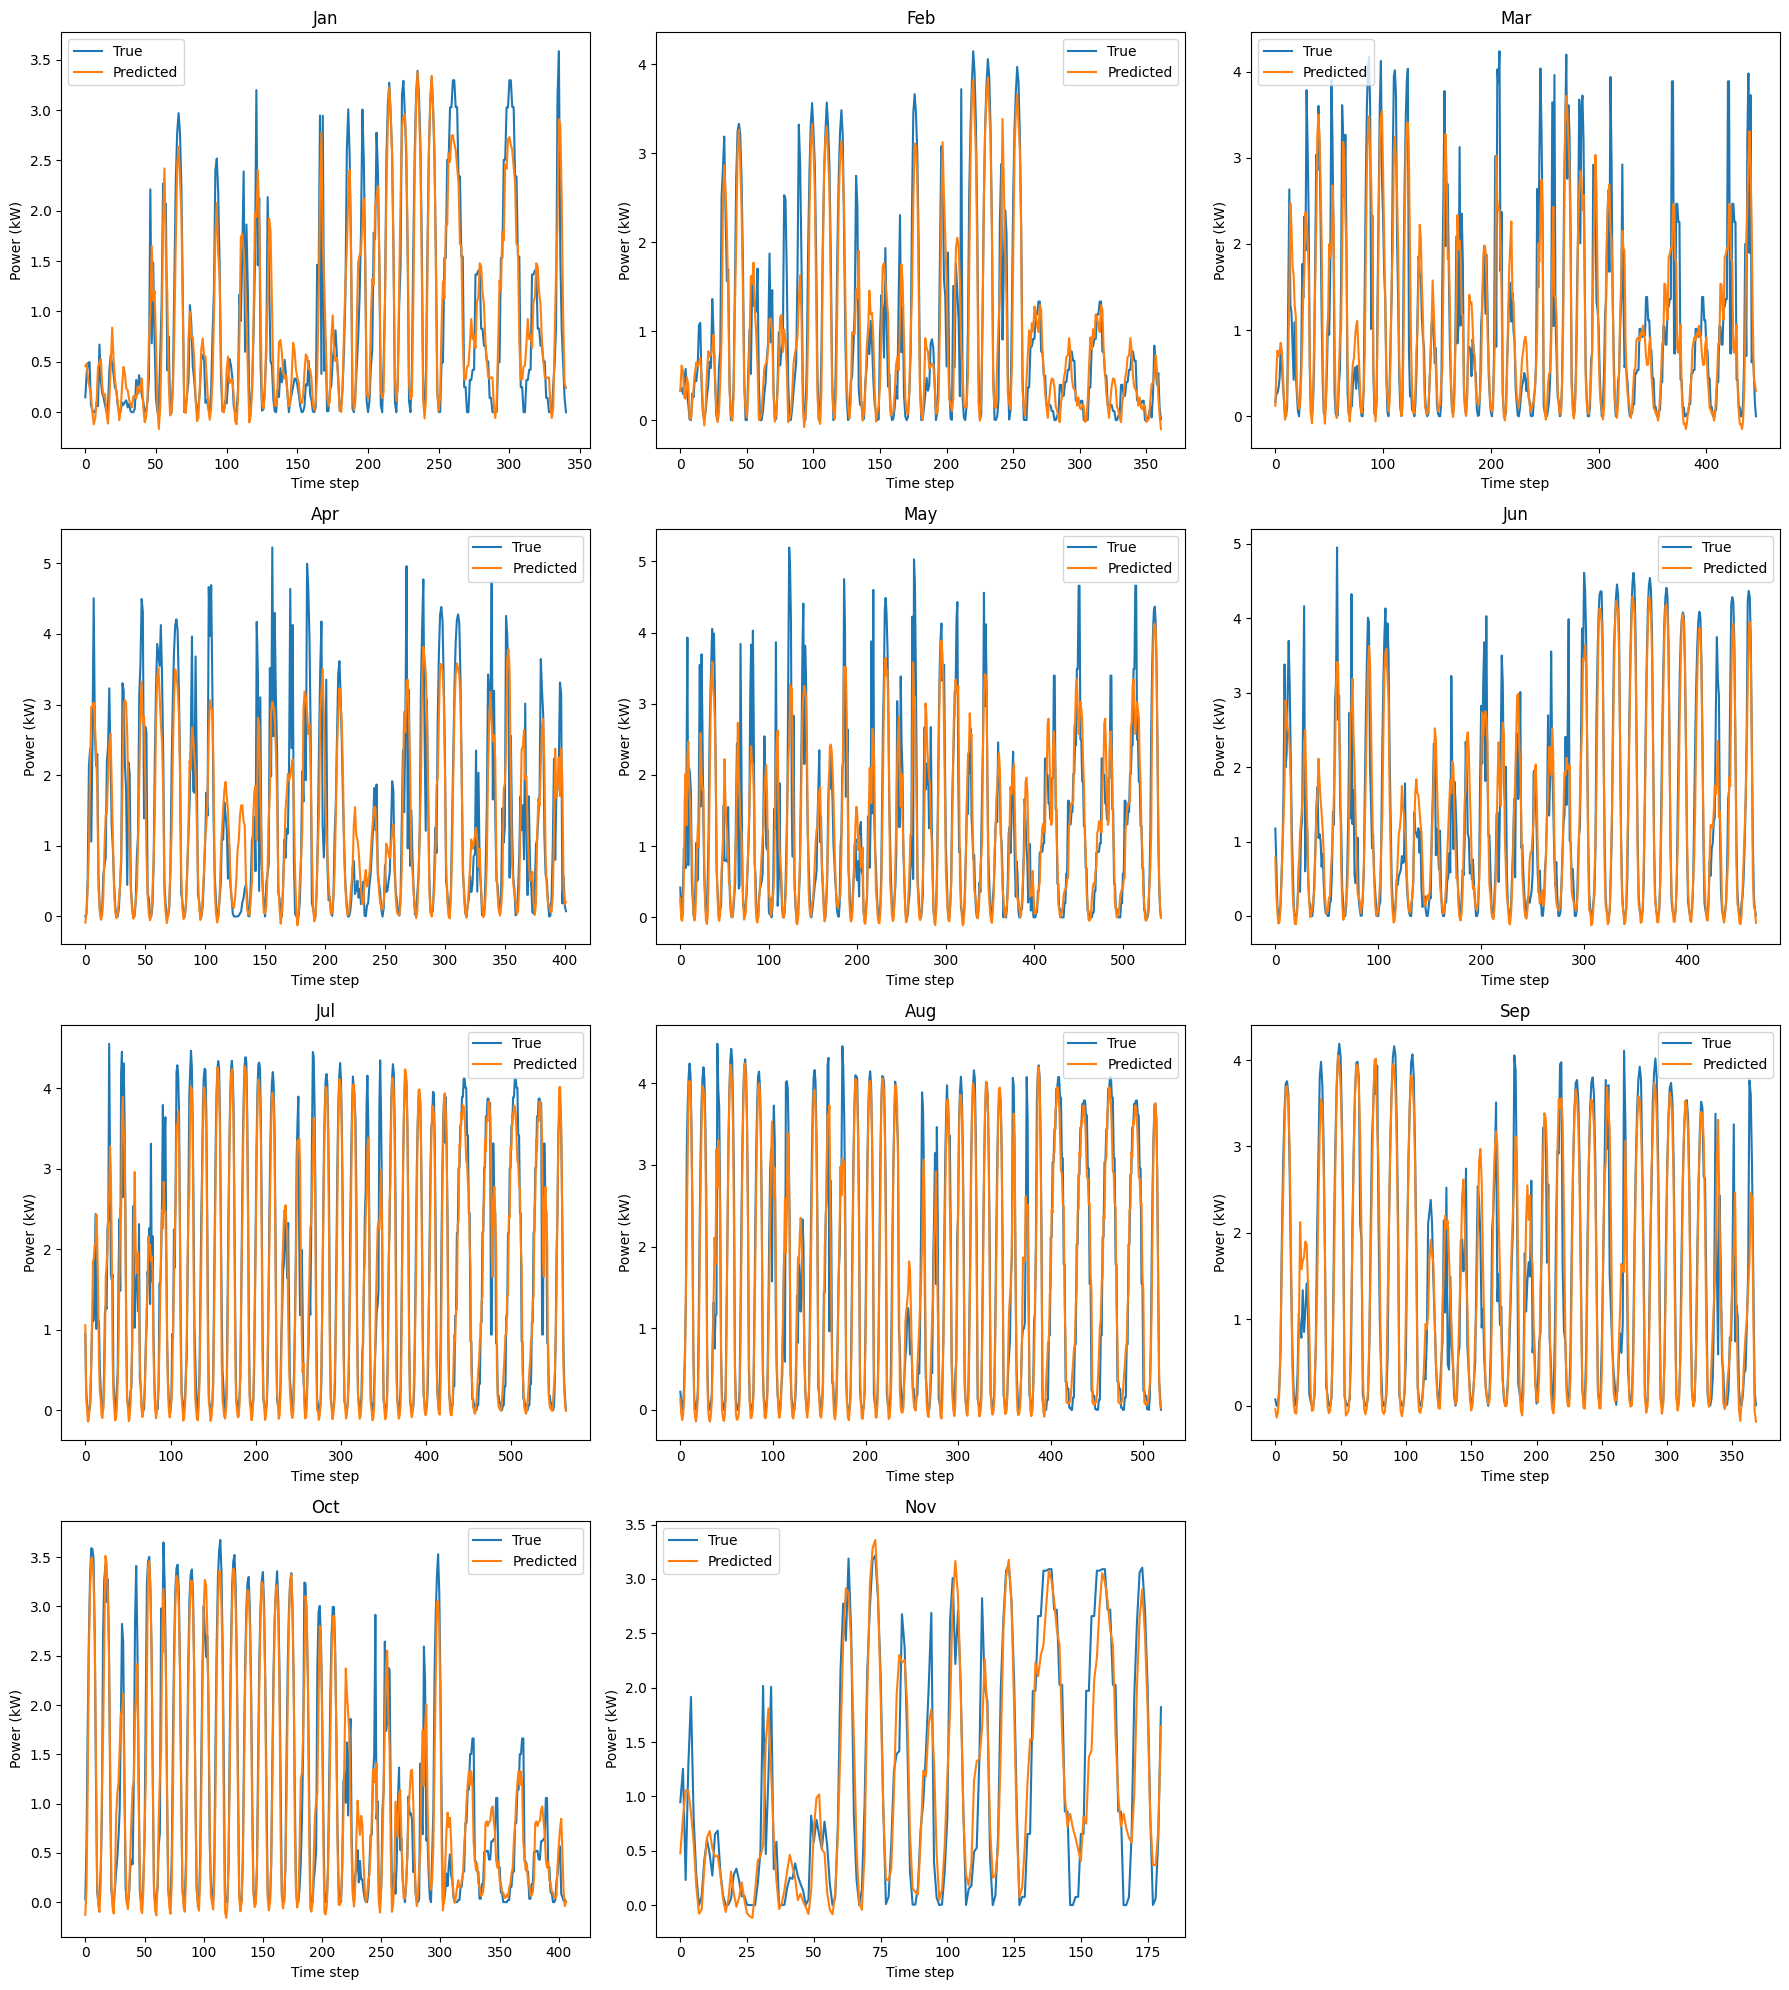

In [9]:

month_name = {
    "01": "Jan","02": "Feb","03": "Mar","04": "Apr",
    "05": "May","06": "Jun","07": "Jul","08": "Aug",
    "09": "Sep","10": "Oct","11": "Nov","12": "Dec"
}

def make_sequences(X, seq_len=SEQ_LEN):
    return np.array([X[i:i+seq_len] for i in range(len(X)-seq_len)])

cols = 3
rows = math.ceil(len(by_month_data) / cols)
fig, axs = plt.subplots(rows, cols, figsize=(18, 5*rows))
plt.subplots_adjust(hspace=0.6)
axs = axs.flatten()

idx = 0
for key in sorted(by_month_data):
    cond_df = by_month_data[key]["cond"][0]
    prod_df = by_month_data[key]["prod"][0]
    month_df = cond_df.merge(prod_df, on=["month","day","time"], how="left")
    month_df["hour"]   = month_df["time"].str.extract(r'(\d+):').astype(int)

    df = month_df[init_features + ["power"]].dropna().reset_index(drop=True)
    X_scaled = init_scaler.transform(df[init_features])
    y_scaled = target_scaler.transform(df[["power"]])
    X_seq = make_sequences(X_scaled)
    y_seq = y_scaled[SEQ_LEN:]

    y_pred_scaled = model.predict(X_seq, verbose=0)[1]
    acc_vec = (1 - np.abs(y_pred_scaled - y_seq)) * 100
    month_acc = acc_vec.mean()
    print(f"{month_name[key]} accuracy (scaled): {month_acc:.2f}%")
    
    y_pred_kw = target_scaler.inverse_transform(y_pred_scaled).flatten()
    y_true_kw = target_scaler.inverse_transform(y_seq).flatten()

    # Plot
    ax = axs[idx]; idx += 1
    ax.plot(y_true_kw, label="True")
    ax.plot(y_pred_kw, label="Predicted")
    ax.set_title(f"{month_name.get(key, key)}")
    ax.set_xlabel("Time step")
    ax.set_ylabel("Power (kW)")
    ax.legend()

for j in range(idx, len(axs)):
    axs[j].axis("off")

plt.tight_layout()
plt.show()